### TF-IDF, LDA and WordCloud ###

In [1]:
input_movie = input('Enter a movie you like: ')

Enter a movie you like: The jungle book 


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from time import time
import numpy as np

# n_features in the maximum of features genereated in TF-IDF
n_features = 1000

# n_topics is the number of topics we choose in LDA, 
# while n_top_words is the maximum of words in each topic
n_topics = 8
n_top_words = 30

# read the .csv file to get all the reviews about all the movies
reviews_movie = pd.read_csv('data2/reviews_movie.csv', encoding = "ISO-8859-1", error_bad_lines=False)

# Select all the reviews about the movie we pick
reviews_movie1=reviews_movie.loc[reviews_movie['movie_name']==str(input_movie)]

### TF-IDF methods to generate features ###

In [3]:
tf_review_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                stop_words='english')
tf_review = tf_review_vectorizer.fit_transform(reviews_movie1.iloc[:,0])

### This function we will use later to genrate all the topic words ###

In [4]:
def get_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([topic_idx, " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])])
        
    return top_words

### Fit LDA models ###

In [5]:
print("Fitting LDA models with tf-idf features, n_features=%d..."% n_features)
lda_re = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda_re.fit(tf_review)
print("done in {}s." .format(format(time()-t0,'.3f')))

Fitting LDA models with tf-idf features, n_features=1000...
done in 0.298s.


### Define the funciton to generate Word Cloud ###

In [6]:
from os import path
import os
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.qualitative import Dark2_8

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Dark2_8.colors[random.randint(0,7)])

font_path=''.join([os.getcwd(),'/data2/FreckleFace-Regular.ttf'])

relevant_path = ''.join([os.getcwd(),'/data2'])
file_names = [fn for fn in os.listdir(relevant_path) if fn.endswith('.jpg')]
img_dict={k:file_names[k] for k in range(len(file_names))}

def wcplot(text, n):
    data_dir = 'data2'
    pwd = os.getcwd() 
    file_names = os.listdir(os.path.join(pwd, data_dir))
    file_ = img_dict[n]
    file_dir = os.path.join(pwd, data_dir, file_)
    mask = imread(file_dir, mode= 'L')

    stopwords = STOPWORDS.copy()
    stopwords.add("int")
    stopwords.add("ext")
    
    wc = WordCloud(background_color="white", max_words=200,mask=mask,stopwords=stopwords,
                   random_state=3,font_path=font_path).generate(text)
    
    wc.recolor(color_func=color_func, random_state=3)
    plt.figure(figsize=(10,10),facecolor='k')
    plt.imshow(wc)
    title = ("top words for topic %d") % n
    plt.title(title)
    pic_name = ('pic_topic_%d.png') % n

    wc.to_file(pic_name)
    plt.axis("off")
    
    plt.show()

### out_words is all the topic words we generated with our algorithm ###

In [7]:
tf_re_feature_names = tf_review_vectorizer.get_feature_names()
# We use the function get_top_words we mentioned before
topic_top_words = get_top_words(lda_re, tf_re_feature_names, n_top_words)
out_words=' '.join([topic_top_words[i][1] for i in range(n_topics)])
# Banned words are those meanless ones including 'film', 'movie', and words in the movie name
bannedWord = ['film','movie']+[i.lower() for i in input_movie.split()]
out_words=' '.join(i for i in out_words.split() if i not in bannedWord)

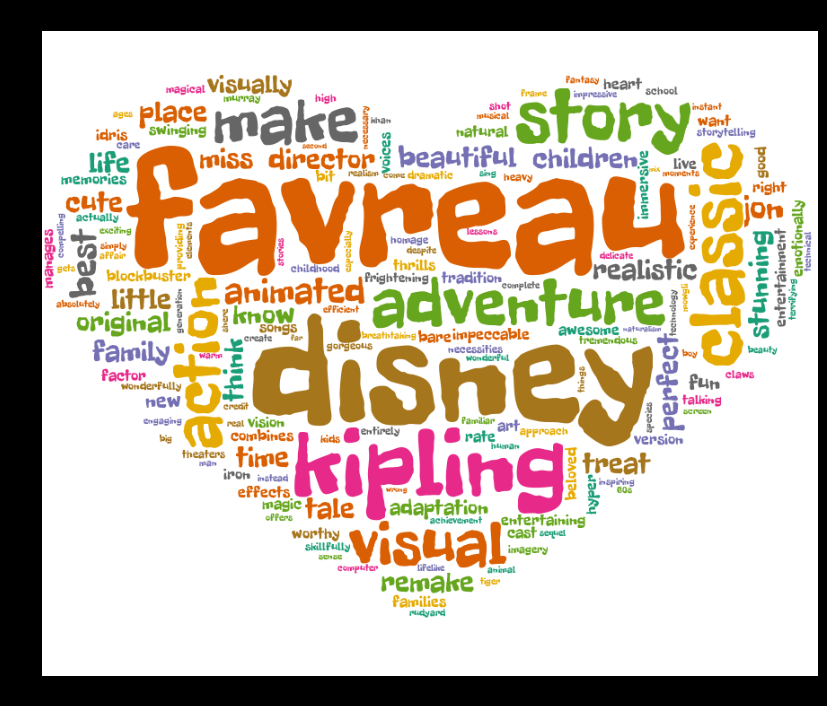

In [9]:
wcplot(out_words,random.randint(0,len(img_dict)-1))